In [1]:
cd /private/home/ccaucheteux/hasson-syntaxe-vs-semantics/

/private/home/ccaucheteux/hasson-syntaxe-vs-semantics


In [2]:
ls scores

/bin/bash: /public/apps/anaconda3/2020.11/lib/libtinfo.so.6: no version information available (required by /bin/bash)
100-concat-multisubjects-0206-wordemb/  multisubjects-0130/
200-concat-multisubjects-0201-valid/    multisubjects-concat/
concat-multisubjects-0130/              multisubjects-control/
concat-multisubjects-0201/              multisubjects-controls/
concat-multisubjects-0201-newformat/    regressout-multisubjects-0201-valid/
concat-multisubjects-0201-seeds/        regressout-single-subjects-0206/
concat-multisubjects-0201-valid/        regressout-single-subjects-0209/
concat-single-subjects-0201/            single-subject-multitasks/
concat-single-task-0201/                single-subject-multitasks-0129/
concat-single-task-0206/                single-subject-multitasks-concat/
gpt2-single-subjects-multitasks/        single-subjects-0130/
median-multisubjects-0130/              test/
multisubjects/


In [3]:
import pandas as pd
import numpy as np
from src import paths

In [4]:
from nilearn import plotting
import nilearn
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

In [5]:
from mne.stats import fdr_correction
from scipy.stats import wilcoxon 

def get_pvals(r, corrected=True, alpha=0.05):
    # r of shape (dim, n_samples)
    pvals = [wilcoxon(x)[1] if not np.allclose(x, 0) else 1 for x in r]
    if corrected:
        pvals = fdr_correction(pvals, alpha=alpha, method='indep')[0]
    else:
        pvals = np.array(pvals)<=alpha
    return pvals

def set_ticks(ax, x_values = None, y_values = None):
    if x_values is not None:
        ax.set_xticks(x_values)
        ax.set_xticklabels([f"{x:.2f}".replace("0.", ".") for x in x_values])
    if y_values is not None:
        ax.set_yticks(y_values)
        ax.set_yticklabels([f"{x:.2f}".replace("0.", ".") for x in y_values])

In [6]:
import matplotlib.pyplot as plt
from scipy.stats import sem
import seaborn as sns

def gather_scores(scores):
    result = {}
    for d in scores:
        for k, v in d.items():
            if k in result:
                result[k].append(v)
            else:
                result[k] = [v]
        
    # Names
    names = result.keys()
    names = [p.name.split(".pth")[0] for p in names]
    scores = np.stack(list(result.values()))
    scores = np.transpose(scores, (0, 2, 1))
    return scores, names

In [7]:
def get_scores(exp_name):
    params = np.load(paths.scores / exp_name / "params.npy", allow_pickle=True).item()
    feature_labels = params["FEATURE_LABELS"]

    df_paths = pd.read_csv(paths.scores / exp_name / "results_path.csv")

    # Load scores
    from pathlib import Path
    df_paths["is_file"] = df_paths["save_file"].apply(lambda x : Path(x).is_file())
    df_paths = df_paths.query("is_file")

    temp = df_paths["save_file"].apply(lambda x : np.load(x, allow_pickle=True).item())
    is_not_none = np.array([i is not None for i in temp])
    df_paths = df_paths.query("@is_not_none")

    temp = temp[is_not_none]
    scores = np.stack([np.stack([np.stack(list(row[hemi].values())) for hemi in ["L", "R"]], axis=1) for row in temp], axis=1)
    #scores = {feature_labels[i] : scores[i] for i in range(len(scores))}
    del temp
    
    return scores, feature_labels


In [8]:
EXP_NAME = "single-subjects-0130"
EXP_NAME = "concat-single-subjects-0201"
EXP_NAME = "regressout-single-subjects-0209"
CONCAT = True

In [9]:
from pathlib import Path
df_path = pd.read_csv(paths.scores / EXP_NAME / "results_path.csv")
df_path["is_file"] = df_path.save_file.apply(lambda x : Path(x).is_file())
df_path = df_path.query("is_file")
df_path["both_hemi"] = df_path.groupby(["feature_file", "subject"])["hemi"].transform("count")==2
df_path = df_path.query("both_hemi")
df_path = df_path.sort_values("feature_file")

In [10]:
df_path.query("hemi=='L'").save_file.values[0]

'/private/home/ccaucheteux/hasson-syntaxe-vs-semantics/scores/regressout-single-subjects-0209/3_phone_features/sub-001_L.npy'

In [11]:
np.load('/private/home/ccaucheteux/hasson-syntaxe-vs-semantics/scores/single-subjects-0130/3_phone_features/sub-001_L.npy', allow_pickle=True)[0]

{PosixPath('/private/home/ccaucheteux/hasson-syntaxe-vs-semantics/data/embeddings/0130_features/%s/3_phone_features.pth'): array([-0.04862569,  0.03762508,  0.06789906, ...,  0.10174044,
         0.07942063,  0.05702521])}

In [12]:
scores, names = {}, {}
for hemi in ["L", "R"]:
    temp = df_path.query("hemi==@hemi").save_file.apply(lambda x: np.load(x, allow_pickle=True))
    is_not_none = np.array([i is not None for i in temp])
    temp = temp[is_not_none]
    temp = [tp[0] for tp in temp]
    scores[hemi], names[hemi] = gather_scores(temp)

In [15]:
assert (np.array(names["L"]) == np.array(names["R"])).all()
scores = np.stack([scores["L"], scores["R"]], axis=1)
names = names["L"].copy()

In [17]:
names

['3_phone_features',
 'phone_embedding_sum-gpt2-9.equiv-random-mean-10',
 'phone_sum-gpt2-0.equiv-random-mean-10',
 'phone_sum-gpt2-0',
 'phone_sum-gpt2-9.equiv-random-mean-10',
 'phone_sum-gpt2-9']

In [16]:
scores.shape

(6, 2, 40962, 305)

In [21]:
test = scores.copy()
test -= np.percentile(test, 1, axis=-1)[:,:,:,None]
test /= np.percentile(test, 99, axis=-1)[:,:,:,None]

<ipython-input-21-b680916c4c2f>:3: RuntimeWarning: invalid value encountered in true_divide
  test /= np.percentile(test, 99, axis=-1)[:,:,:,None]


In [23]:
test.shape

(6, 2, 40962, 305)

In [27]:
np.nanmean(scores.std(axis=-1), (1, 2))

array([0.06278981, 0.06432184, 0.05856412, 0.06107135, 0.06366614,
       0.06324874])

In [25]:
np.nanmean(test.std(axis=-1), (1, 2))

array([0.19905911, 0.20003557, 0.19773224, 0.19865352, 0.20061256,
       0.20123507])

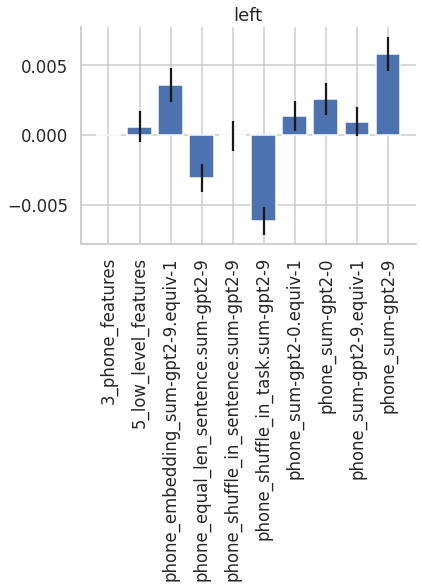

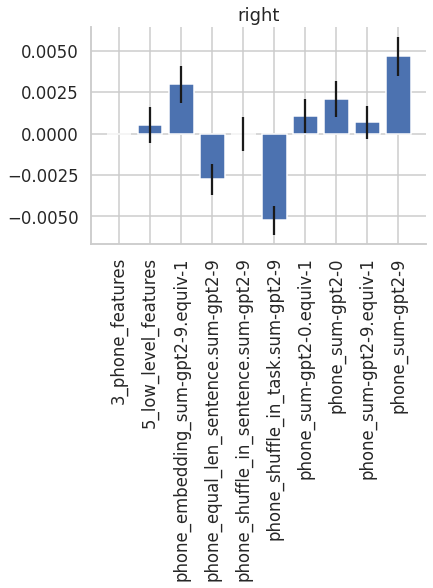

In [119]:
if CONCAT:
    scores -= scores[0]

sns.set("talk", "whitegrid")

for i in range(2):
    r = scores[:,i]
    # Scores
    means = np.nanmean(np.nanmean(r, 1), -1)
    sems = sem(np.nanmean(r, 1), -1)

    # Plot
    plt.figure(facecolor="w")
    plt.bar(names, means, yerr=sems)
    plt.xticks(rotation="vertical")
    sns.despine()
    plt.title(["left", "right"][i])
    #set_ticks(ax, y_values=[0, .08])
    plt.show()

In [120]:
embed = names.index('phone_sum-gpt2-0')
embed_shuffle = names.index('phone_sum-gpt2-0.equiv-1')

middle = names.index('phone_sum-gpt2-9')
middle_shuffle = names.index('phone_sum-gpt2-9.equiv-1')
middle_shuffle_embed = names.index('phone_embedding_sum-gpt2-9.equiv-1')

In [121]:
rows = ["Syntax", "Semantic", "Syntax + Semantics"]
cols = ["Lexical", "Compositional", "Lexical + Compositional"]


In [122]:
labels = np.empty((len(rows), len(cols)), dtype="<U30")
labels[0, 0] = "$L0_{syneq}$"
labels[0, 1] = "$L9_{syneq} - L0_{syneq}$" #r[middle_shuffle] - r[embed_shuffle]
labels[0, 2] = "$L9_{syneq}$" #r[middle_shuffle]

labels[1, 0] = "$L0 - L0_{syneq}$" #r[embed] - r[embed_shuffle]
labels[1, 1] = "$L9 - (L9_{syneq} + L0)$" #r[middle] - r[middle_shuffle_embed]
labels[1, 2] = "$L9 - L9_{syneq}$" #r[middle] - r[middle_shuffle]

labels[2, 0] = "$L0$" #r[embed]
labels[2, 1] = "$L9 - L0$" #r[middle] - r[embed]
labels[2, 2] = "$L9$" #r[middle]

In [123]:
data = np.zeros((len(rows), len(cols), *scores.shape[1:]))
data[0, 0] = scores[embed_shuffle]
data[0, 1] = scores[middle_shuffle] - scores[embed_shuffle]
data[0, 2] = scores[middle_shuffle]

data[1, 0] = scores[embed] - scores[embed_shuffle]
data[1, 1] = scores[middle] - scores[middle_shuffle_embed]
data[1, 2] = scores[middle] - scores[middle_shuffle]

data[2, 0] = scores[embed]
data[2, 1] = scores[middle] - scores[embed]
data[2, 2] = scores[middle]

<ipython-input-124-bf5d43823d5c>:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(G[0, j+1])


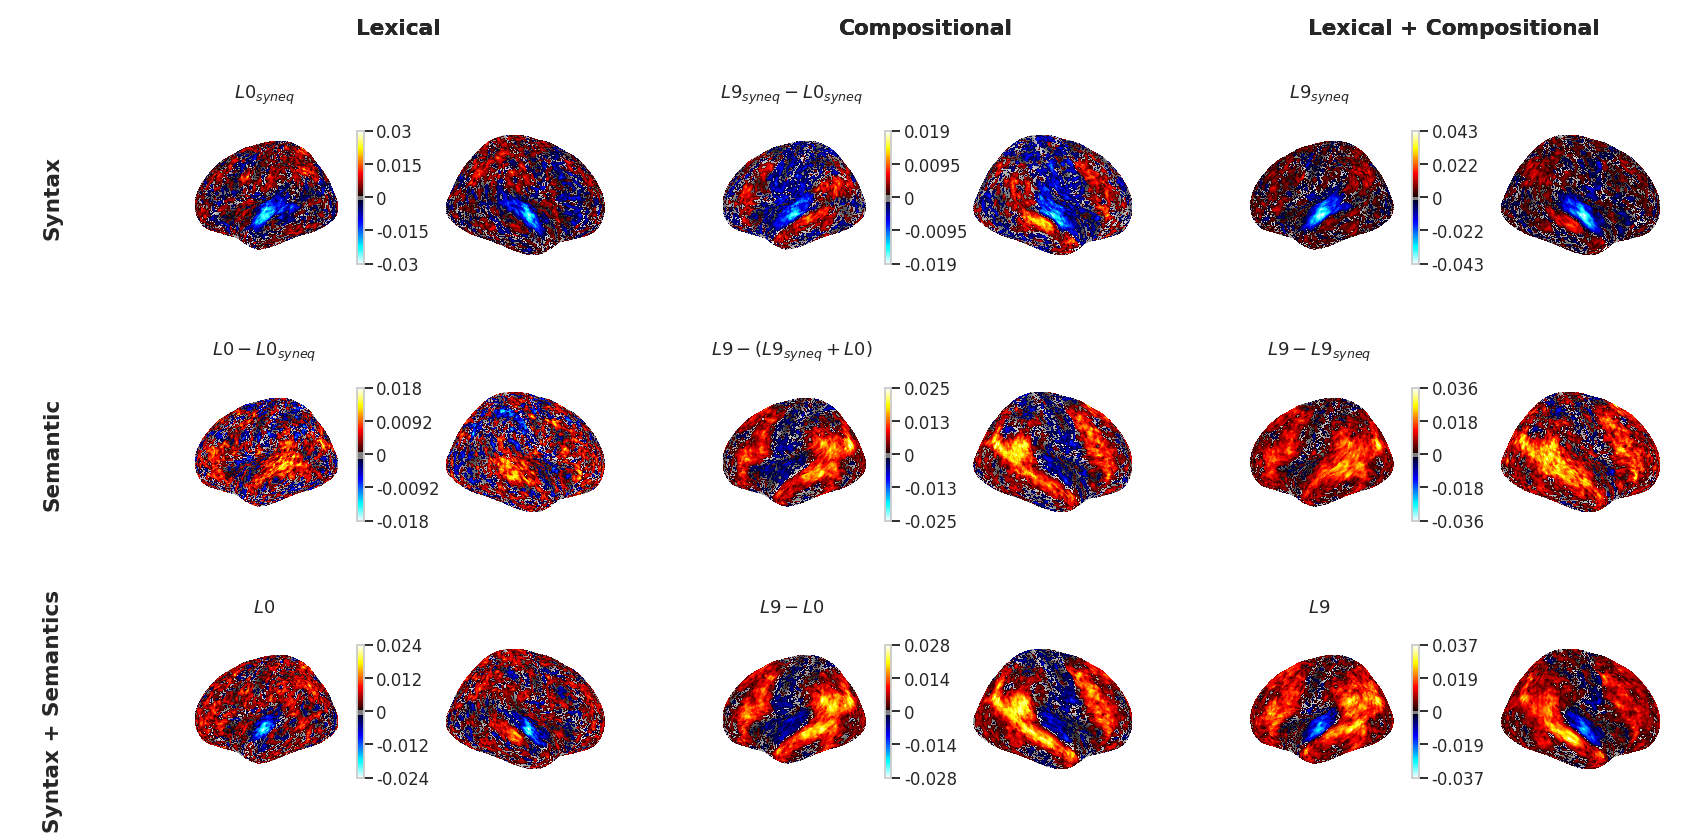

In [124]:
from matplotlib.gridspec import GridSpec, SubplotSpec

hemis = ["lh", "rh"]

fig = plt.figure(figsize=(30, 15), facecolor="w")
G = GridSpec(nrows=len(rows)+1, ncols=len(cols)+1, 
            height_ratios=[.2, 1, 1, 1], width_ratios=[.2, 1, 1, 1])
title_opts = dict(fontsize="large", verticalalignment="center",
            horizontalalignment="center", fontweight="bold")

for i, row in enumerate(rows):
    ax = plt.subplot(G[i+1, 0])
    plt.text(.5, .5, row, rotation=90, **title_opts)
    ax.axis("off")
    
    for j, col in enumerate(cols):
        
        ax = plt.subplot(G[0, j+1])
        plt.text(.5, .5, col, **title_opts)
        ax.axis("off")
        
        g0 = G[(i+1), (j+1)].subgridspec(nrows=1, ncols=2)
        
        for h, hemi in enumerate(["left", "right"]):
            r = data[i, j, h].mean(-1)
            
            ax = plt.subplot(g0[0, h], projection="3d")
            plotting.plot_surf_stat_map(
                surf_mesh = str(paths.surf_dir / f"{hemis[h]}.inflated"),
                stat_map = r,
                hemi=hemi,
                axes=ax,
                vmax=None, #. if "[-]" not in dico_labels[key] else None, 
                threshold=0.001,
                bg_map= str(paths.surf_dir / f"{hemis[h]}.sulc"),
                colorbar=(h==0),
                title=None if h==1 else labels[i, j],            
            )
            ax.set_zorder(-h)
            #set_ticks(ax, y_values=[r.min(), 0, r.max()])
            
plt.show()

In [125]:
data_pvals = data.copy()
for i in range(data_pvals.shape[0]):
    for j in range(data_pvals.shape[1]):
        for h in range(data_pvals.shape[2]): # Hemis
            pvals = get_pvals(data[i, j, h], corrected=False)
            data_pvals[i, j, h, ~pvals] = 0
            print(labels[i, j], pvals.sum()/len(pvals))

$L0_{syneq}$ 0.04164835701381769
$L0_{syneq}$ 0.03215175040281236
$L9_{syneq} - L0_{syneq}$ 0.0009765148186123725
$L9_{syneq} - L0_{syneq}$ 0.0020995068600166006
$L9_{syneq}$ 0.04223426590498511
$L9_{syneq}$ 0.03163908012304087
$L0 - L0_{syneq}$ 0.008739807626580734
$L0 - L0_{syneq}$ 0.010570772911478931
$L9 - (L9_{syneq} + L0)$ 0.03425125726282896
$L9 - (L9_{syneq} + L0)$ 0.029295444558371173
$L9 - L9_{syneq}$ 0.11986719398466872
$L9 - L9_{syneq}$ 0.08715394756115424
$L0$ 0.03898735413309897
$L0$ 0.02697622186416679
$L9 - L0$ 0.08026951808993701
$L9 - L0$ 0.06640300766564132
$L9$ 0.24283482251843172
$L9$ 0.170719203163908


<ipython-input-126-3f758f72e54e>:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(G[0, j+1])


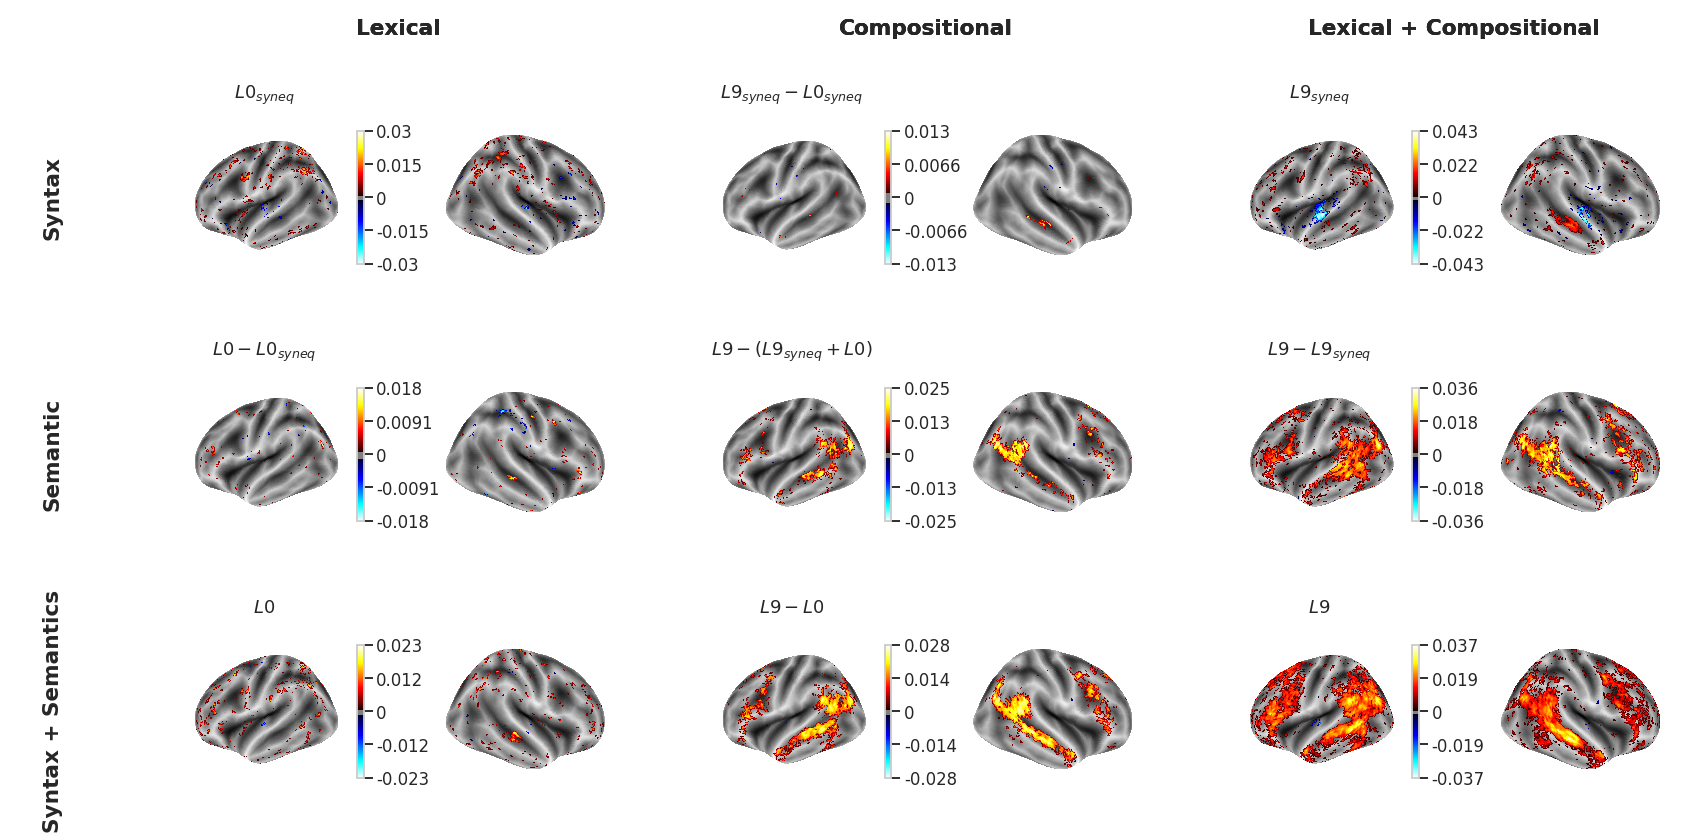

In [126]:
from matplotlib.gridspec import GridSpec, SubplotSpec

hemis = ["lh", "rh"]

fig = plt.figure(figsize=(30, 15), facecolor="w")
G = GridSpec(nrows=len(rows)+1, ncols=len(cols)+1, 
            height_ratios=[.2, 1, 1, 1], width_ratios=[.2, 1, 1, 1])
title_opts = dict(fontsize="large", verticalalignment="center",
            horizontalalignment="center", fontweight="bold")

for i, row in enumerate(rows):
    ax = plt.subplot(G[i+1, 0])
    plt.text(.5, .5, row, rotation=90, **title_opts)
    ax.axis("off")
    
    for j, col in enumerate(cols):
        
        ax = plt.subplot(G[0, j+1])
        plt.text(.5, .5, col, **title_opts)
        ax.axis("off")
        
        g0 = G[(i+1), (j+1)].subgridspec(nrows=1, ncols=2)
        
        for h, hemi in enumerate(["left", "right"]):
            r = data_pvals[i, j, h].mean(-1)
            
            ax = plt.subplot(g0[0, h], projection="3d")
            plotting.plot_surf_stat_map(
                surf_mesh = str(paths.surf_dir / f"{hemis[h]}.inflated"),
                stat_map = r,
                hemi=hemi,
                axes=ax,
                vmax=None, #. if "[-]" not in dico_labels[key] else None, 
                threshold=0.001,
                bg_map= str(paths.surf_dir / f"{hemis[h]}.sulc"),
                colorbar=(h==0),
                title=None if h==1 else labels[i, j],            
            )
            ax.set_zorder(-h)
            #set_ticks(ax, y_values=[r.min(), 0, r.max()])
            
plt.show()

In [128]:
text = ["\n", " ",
" -- ", ". ",
" – ", ", ",
"–", "-",
' "', ". ",
' "', ". ",
'" ', ". ",
'". ', ". ",
'." ', ". ",
"?. ", "? ",
",. ", ", ",
"...", ". ",
".. ", ". ",
":", ". ",
"…", ". ",
"-", " ",
"  ", " ",]
np.unique(text)

array(['\n', ' ', '  ', ' "', ' -- ', ' – ', '" ', '". ', ', ', ',. ',
       '-', '. ', '." ', '.. ', '...', ':', '? ', '?. ', '–', '…'],
      dtype='<U4')

In [129]:
np.unique([i.strip() for i in text])

array(['', '"', '".', ',', ',.', '-', '--', '.', '."', '..', '...', ':',
       '?', '?.', '–', '…'], dtype='<U3')